<a href="https://colab.research.google.com/github/giseldo/neolegibilitymodel/blob/main/7764.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [498]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVR
import textstat
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [499]:
name = "7764"
filename = "../data/neo/csv/{}.csv".format(name)
df = pd.read_csv(filename)
df.head()

,issuekey,created,title,description,storypoints
0,29688087,2020-01-17 00:50:48.022,Update templates for website merge requests,Relates to &232 and #6109 \r\n\r\nGoals:\r\n\r...,1
1,29682716,2020-01-16 19:21:38.595,Make sure that we Capture Advanced Search in o...,This was raised in the PM & Engineering meetin...,1
2,29644971,2020-01-15 21:17:03.379,Propose new IA for Brand and Digital Handbook,## Goals\r\nPropose new IA for Brand and Digit...,1
3,29494181,2020-01-10 19:20:50.351,Cache `node_modules` for www-gitlab-com pipelines,# UPDATE NOTE: This MR will not be implemented...,1
4,29437529,2020-01-09 10:26:51.545,Disable all remaining unnecessary jobs in pipe...,Similar to https://gitlab.com/gitlab-com/www-g...,1


In [500]:
df.shape

(355, 5)

Esse conjunto de dados tem 355 User Stories.

In [501]:
# apagar as colunas 
df["context"] = df["title"] + df["description"]
df = df.drop(['created', 'issuekey', 'title', 'description'], axis=1)
df['context'] = df['context'].astype(str)
df.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


Foi apagado as colunas created, issuekey, title e description.

In [502]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
storypoints,355.0,2.732394,7.186298,0.0,1.0,2.0,3.0,128.0


In [503]:
value_count = df["storypoints"].value_counts().sort_index()

Text(0, 0.5, 'Contagem de vezes')

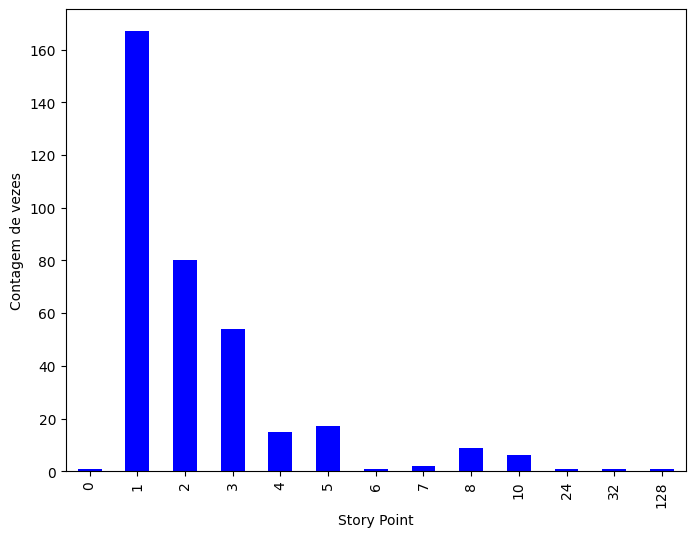

In [504]:
plt.figure(figsize=(8,6))
value_count.plot(kind='bar', color=['blue'])
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes")

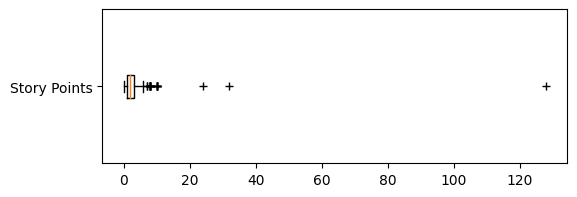

In [505]:
plt.figure(figsize=(6,2))
plt.boxplot(df['storypoints'], vert=False, sym="+")
plt.yticks([1], ['Story Points'])
plt.show()

<AxesSubplot: >

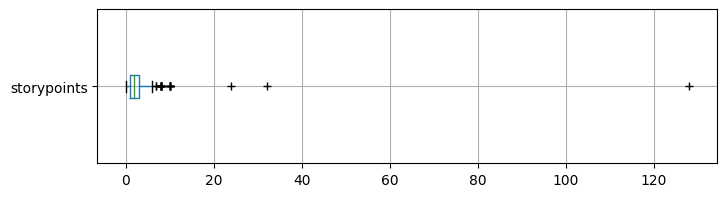

In [506]:
plt.figure(figsize=(8,2))
df.boxplot(column='storypoints', vert=False, sym="+")

In [507]:
# remover outliers
mean = df["storypoints"].mean()
std_dev = df["storypoints"].std()
outlier_cutoff = 2 * std_dev
df_clean = df[(df["storypoints"] >= mean - outlier_cutoff) & (df["storypoints"] <= mean + outlier_cutoff)]
df_clean.shape

(352, 2)

<AxesSubplot: >

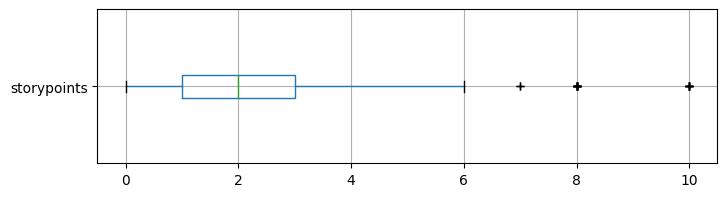

In [508]:
plt.figure(figsize=(8,2))
df_clean.boxplot(column='storypoints', vert=False, sym="+")

In [509]:
value_count_clean = df_clean["storypoints"].value_counts().sort_index()

Text(0, 0.5, 'Contagem de vezes')

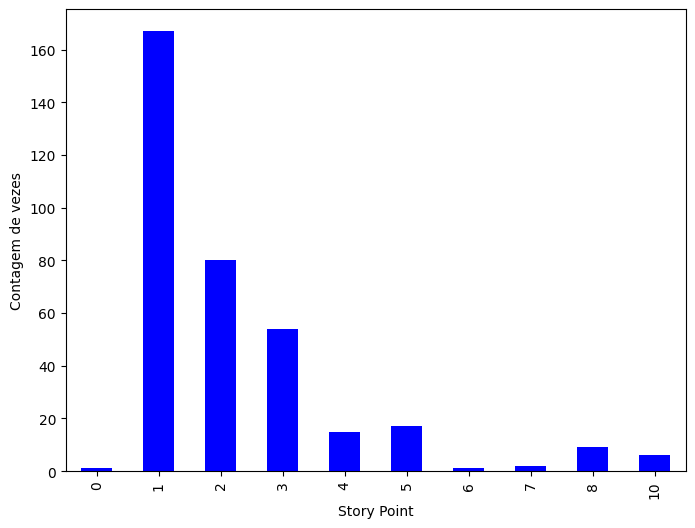

In [510]:
plt.figure(figsize=(8,6))
value_count_clean.plot(kind='bar', color=['blue'])
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes")

In [511]:
# separação treino e teste
num_linhas_treino = int(len(df_clean) * 0.7)
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [512]:
storypoint_medio = dados_treino["storypoints"].mean()
storypoint_medio

2.158536585365854

Em média, nesse conjunto de dados, o Story Point Médio dos dados de treino é de 2.15

In [513]:
def mean_absolute_error(y_true, y_pred):
  """
  Calcula o Mean Absolute Error (MAE), entre os valores verdadeiros (y_true) e os valores previstos (y_pred)

  Args:
    y_true: Uma lista ou array Numpy dos valores verdadeiros.
    y_pred: Uma lista ou array NumPy dos valores previstos.

  Returns:
    mae: O Mean Absolute Error entre y_true e y_pred
  """
  if len(y_true) != len(y_pred):
    raise ValueError("Os tamanhos de y_true e y_pred devem ser iguais")
  absolute_Errors =[abs(true-pred) for true, pred in zip(y_true, y_pred)]
  mae = sum(absolute_Errors) / len(y_true)
  return mae

# Media

In [514]:
lista_y_pred = [storypoint_medio] * len(dados_teste)
mae_media_sp = mean_absolute_error(dados_teste["storypoints"], lista_y_pred)
df_results = pd.DataFrame(data=[['Media', mae_media_sp, "red"]], columns=["modelo", "MAE Teste", "cor"])
df_results

,modelo,MAE Teste,cor
0,Media,1.319374,red


O MAE de treino, caso seja utilizado o Story Point Médio do dado de Treino é 1.31.

Ou seja, se sempre atribuirmos um valor de 2.15 (o Story Point Médio) a uma nova User Story ele estará em média errado 1.31 Story Point.

# Neo Legibility Model

In [515]:
# novos atributos
colunas = ['gunning_fog', 'polarity','subjectivity']
df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean['subjectivity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# separação treino e teste com novos atributos
num_linhas_treino = int(len(df_clean) * 0.7)
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]
# modelo Legibility
model = SVR()
model.fit(dados_treino[colunas], dados_treino["storypoints"])
y_pred = model.predict(dados_teste[colunas])
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'Neo Legibility', 'MAE Teste': mae_tfidf, 'cor': "orange"}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\1926589208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\1926589208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\1926589208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

,modelo,MAE Teste,cor
0,Media,1.319374,red
1,Neo Legibility,1.221740,orange


In [533]:
corr = df_clean[['gunning_fog', 'polarity', 'subjectivity', 'storypoints']].corr()
corr

,gunning_fog,polarity,subjectivity,storypoints
gunning_fog,1.000000,0.087776,0.050378,0.170286
polarity,0.087776,1.000000,0.361146,0.029430
subjectivity,0.050378,0.361146,1.000000,-0.017237
storypoints,0.170286,0.029430,-0.017237,1.000000


<AxesSubplot: >

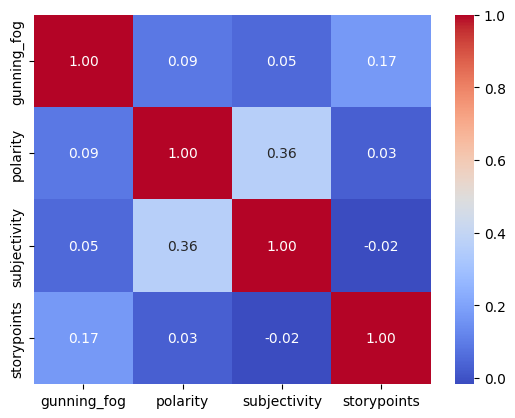

In [538]:
import seaborn as sns
sns.heatmap(corr, annot=True, cmap='coolwarm',  fmt=".2f")

# Antes pré-processamento

In [516]:
df_clean.head()

,storypoints,context,gunning_fog,polarity,subjectivity
0,1,Update templates for website merge requestsRel...,8.85,0.133333,0.966667
1,1,Make sure that we Capture Advanced Search in o...,7.19,0.110714,0.366270
2,1,Propose new IA for Brand and Digital Handbook#...,17.34,0.070350,0.372007
3,1,Cache `node_modules` for www-gitlab-com pipeli...,14.98,0.086750,0.431778
4,1,Disable all remaining unnecessary jobs in pipe...,11.86,-0.133333,0.766667


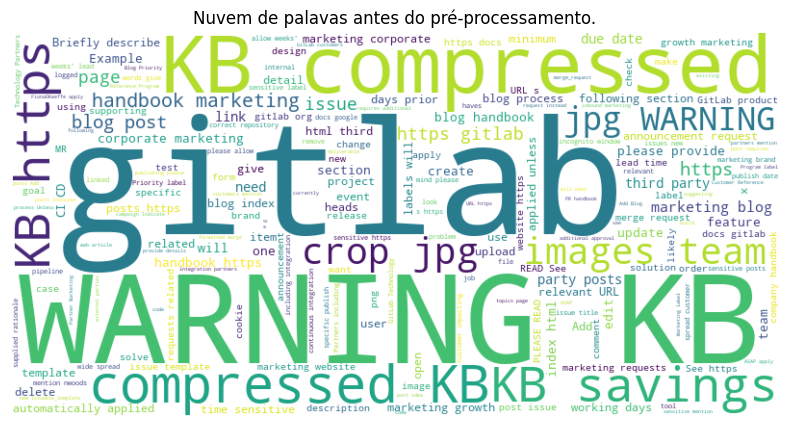

In [517]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de palavas antes do pré-processamento.")
plt.show()

In [518]:
vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())

bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())

bow_df_treino

,00,000,0014m00001h35gdqaq,01,02,02_at_09,03,032,03_at_13,03_at_14,...,zamirmartinsfilho,zeffmorgan,zegerjan,zhll9r1er7ilskpzriiff3,zj,zjx5qwyfbkc,zoom,zsuzsannakovacs,zzplok3lqqwzj5u7svzujvfa,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


O bow gerou 5102 colunas, com o pré-processamento isso irá diminuir.

# Depois pre-processamento

In [519]:
# processamento do texto
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

def remover_stopwords(texto):
  palavras = word_tokenize(texto)
  palavas_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stop_words]
  return ' '.join(palavas_sem_stopwords)

def remover_urls(texto):
    return re.sub(r'http\S+|www\S+', ' ', texto)

def remover_html_tags(texto):
    return re.sub(r'<[^>]+>', ' ', texto)

def remover_palavras_com_numeros(texto):
    return re.sub(r'\b\w*\d\w*\b', ' ', texto)

def remover_pontuacoes(texto):
    return re.sub(r'[^\w\s]', ' ', texto)

def remover_caracteres_especiais(texto):
    return re.sub(r'[^A-Za-z0-9\s]', '', texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [520]:
# remover stopwords
df_clean["context"] = df_clean['context'].apply(remover_stopwords)
df_clean["context"] = df_clean['context'].apply(remover_urls)
df_clean["context"] = df_clean['context'].apply(remover_html_tags)
df_clean["context"] = df_clean['context'].apply(remover_palavras_com_numeros)
df_clean["context"] = df_clean['context'].apply(remover_pontuacoes)
df_clean["context"] = df_clean['context'].apply(remover_caracteres_especiais)
df_clean["context"] = df_clean["context"].str.replace(r'\s+', ' ', regex=True).str.strip()

C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\2397164545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_stopwords)
C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\2397164545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_urls)
C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\2397164545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [521]:
df_clean.head()

,storypoints,context,gunning_fog,polarity,subjectivity
0,1,Update templates website merge requestsRelates...,8.85,0.133333,0.966667
1,1,Make sure Capture Advanced Search feature feat...,7.19,0.110714,0.366270
2,1,Propose new IA Brand Digital Handbook Goals Pr...,17.34,0.070350,0.372007
3,1,Cache nodemodules pipelines UPDATE NOTE MR imp...,14.98,0.086750,0.431778
4,1,Disable remaining unnecessary jobs pipeline me...,11.86,-0.133333,0.766667


In [522]:
# separação treino e teste (após pré-processamento)
percent_treino = 0.7
num_linhas_treino = int(len(df_clean) * percent_treino)

dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [523]:
vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())

bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())

bow_df_treino

,aakgun,aakritigupta,aaronfriel,aashish,aasimkhan,ab,abbreviation,abbreviations,abd,abilities,...,yxous,zacbadgleycopy,zachrice,zackcuddy,zamirmartinsfilho,zeffmorgan,zegerjan,zj,zoom,zsuzsannakovacs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Reduziu para 4290 colunas

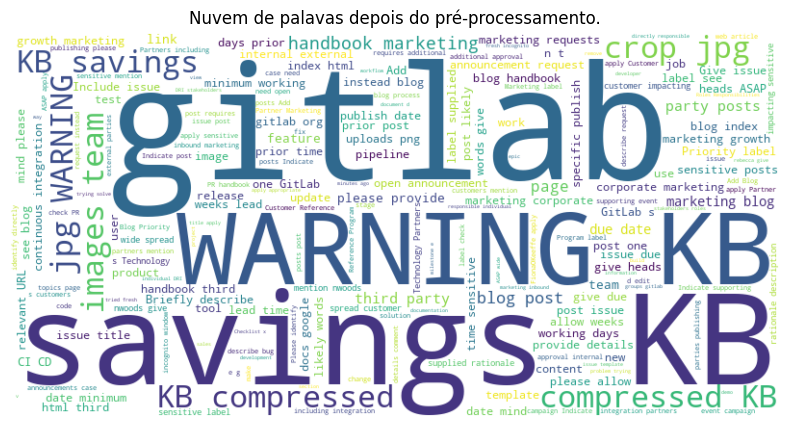

In [524]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Nuvem de palavas depois do pré-processamento.")
plt.axis('off')
plt.show()

# BOW (Bag of words)

In [525]:
model = SVR(kernel='linear')
model.fit(bow_df_treino, dados_treino["storypoints"])
y_pred = model.predict(bow_df_teste)
mae_bow = mean_absolute_error(dados_teste["storypoints"], y_pred)
#df_results = df_results.append({'modelo':'BOW', 'MAE Teste': mae_bow, 'cor': 'green'}, ignore_index=True)
#df_results

# TF-IDF

In [526]:
vec = TfidfVectorizer(max_features=50)
tfidf_matrix_treino = vec.fit_transform(dados_treino["context"])
tfidf_matrix_teste = vec.transform(dados_teste["context"])

model = SVR(kernel='linear')
model.fit(tfidf_matrix_treino, dados_treino["storypoints"])
y_pred = model.predict(tfidf_matrix_teste)
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'TF-IDF', 'MAE Teste': mae_tfidf, 'cor': 'blue'}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_12612\380432324.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'TF-IDF', 'MAE Teste': mae_tfidf, 'cor': 'blue'}, ignore_index=True)


,modelo,MAE Teste,cor
0,Media,1.319374,red
1,Neo Legibility,1.221740,orange
2,TF-IDF,1.247787,blue


# Resumo

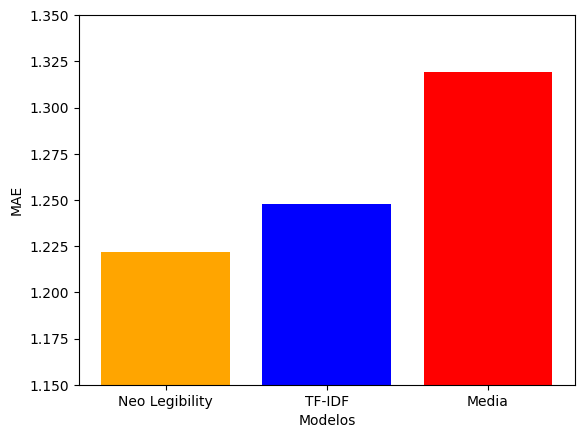

In [530]:
plt.figure()
df_results = df_results.sort_values(by='MAE Teste')
plt.bar(df_results['modelo'], df_results['MAE Teste'], color=df_results['cor'])
plt.ylim(1.15, 1.35)
#plt.title('Comparação do MAE entre os modelos')
plt.xlabel('Modelos')
plt.ylabel('MAE')
plt.show()